# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
import numpy as np
np.random.normal(10,2) # mean and std deviation

11.533831918899086

In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  # time_on_site = random.uniform(10, 600)
  time_on_site = np.random.normal(9.4*60, 3*60)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  #time_on_site = random.uniform(5, 300)
  time_on_site = np.random.normal(7.5*60, 2*60)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=372.4063989763019, mobile=True), User(purchased=True, time_on_site=603.1404967233134, mobile=False), User(purchased=False, time_on_site=528.3930610655879, mobile=False), User(purchased=True, time_on_site=749.7935368489334, mobile=False), User(purchased=False, time_on_site=381.8095582698654, mobile=True), User(purchased=True, time_on_site=455.2760090766264, mobile=True), User(purchased=True, time_on_site=476.85536716044135, mobile=True), User(purchased=True, time_on_site=486.769682925656, mobile=True), User(purchased=True, time_on_site=351.5468913419678, mobile=True), User(purchased=False, time_on_site=366.0235133925573, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,372.406399,True
1,True,603.140497,False
2,False,528.393061,False
3,True,749.793537,False
4,False,381.809558,True


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,85.22021165962144,119.78022002627063,131.3754430555265,135.4757437359226,151.83477961569128,152.13472383329054,153.91251364267646,159.60886758663776,175.31941111211182,178.58642627223685,180.96027270559136,183.28595989141292,187.65056816739775,194.4615041459675,197.70521263545612,198.15355616054785,199.70688916391475,200.95748133121566,203.86934517997818,206.53493127733194,210.13683072687246,210.50226704248357,222.23468186584793,225.31020740147952,226.07774716907227,229.30491363630213,230.34484054495627,230.3598655670765,231.80170705754264,231.9736053485948,233.00244731348738,235.9109271688671,236.39346975755169,237.5722363319461,240.1826907758089,242.79807874446908,244.60189464756604,244.60896395146787,244.6372252869112,244.76783841226427,...,749.7935368489334,753.860753314741,753.9642675249997,760.7458999047882,763.1123158797242,765.6646535126368,767.4379341937674,770.2399147747625,774.3402535076609,778.8227552583973,795.0155528342361,797.0609666872448,798.8153462781958,803.5407940108671,804.910525525072,807.1732039051341,810.7955016668634,813.5031815691091,816.0301486944475,821.4285375607179,823.8993188559548,826.5506209698493,828.5013931261001,831.2530559866523,831.5477260481479,833.0589138287077,843.4508436999404,844.7191416197859,852.6090579523316,854.0002410720044,863.1582487647495,863.2205052488564,865.4526094264644,870.686272191504,897.2027099798149,921.8948840848232,923.2600168023946,958.2061950029431,959.4940067039038,970.6223176911151
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,0,1,1,0,1,0,1,1,1,1,1,1,0,1,0,1,1,0,1,1,1,0,0,1,0,0,0,1,1,0,1,1,1,1,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,1,1,0,1,1,1,0,1,1,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
True,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,1,1,1,0,0,1,0,0,0,0,1,1,1,0,0,...,1,1,1,0,1,1,1,1,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,1,1,0,1,1,1,1,1,1


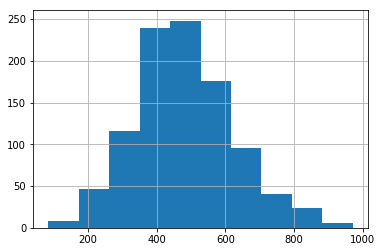

In [0]:
user_data.time_on_site.hist()

In [0]:
#Add one more column
user_data['time_on_site_min']=user_data['time_on_site']/60
user_data.head()

,purchased,time_on_site,mobile,time_on_site_min
0,True,372.406399,True,6.206773
1,True,603.140497,False,10.052342
2,False,528.393061,False,8.806551
3,True,749.793537,False,12.496559
4,False,381.809558,True,6.363493


mobile
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: time_on_site_min, dtype: object

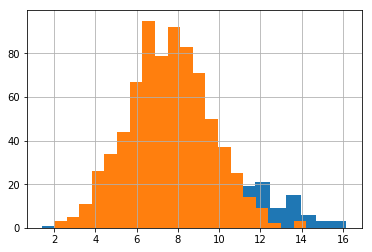

In [0]:
# groupby both mobile and dekstop
user_data.groupby('mobile').time_on_site_min.hist(bins=20)

In [0]:
!pip freeze #pandas==0.24.2


absl-py==0.7.1
alabaster==0.7.12
albumentations==0.1.12
altair==3.1.0
astor==0.8.0
astropy==3.0.5
atari-py==0.1.15
atomicwrites==1.3.0
attrs==19.1.0
audioread==2.1.8
autograd==1.2
Babel==2.7.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
blis==0.2.4
bokeh==1.0.4
boto==2.49.0
boto3==1.9.185
botocore==1.12.185
Bottleneck==1.2.1
branca==0.3.1
bs4==0.0.1
bz2file==0.98
cachetools==3.1.1
certifi==2019.6.16
cffi==1.12.3
chainer==5.4.0
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
cmake==3.12.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.1.3
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.14.6
cvxopt==1.2.3
cvxpy==1.0.15
cycler==0.10.0
cymem==2.0.2
Cython==0.29.12
daft==0.0.4
dask==1.1.5
dataclasses==0.6
datascience==0.10.6
decorator==4.4.0
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.0
distributed==1.25.3
Django==2.2.3
dlib==19.16.0
dm-sonnet==1.34
docopt==0.6.2
docutils==0.14
dopamine-rl==1.0.5
easy

In [0]:
!pip install pandas==0.23.4

     |████████████████████████████████| 8.9MB 4.3MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=0.24.0, but you'll have pandas 0.23.4 which is incompatible.
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


In [0]:
!pip freeze

In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(84.335, 262.301]","(262.301, 439.381]","(439.381, 616.461]","(616.461, 793.542]","(793.542, 970.622]"
purchased,,,,,
False,31,168,178,47,12
True,24,187,246,89,18


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(84.335, 262.301]","(262.301, 439.381]","(439.381, 616.461]","(616.461, 793.542]","(793.542, 970.622]"
purchased,,,,,
False,0.563636,0.473239,0.419811,0.345588,0.4
True,0.436364,0.526761,0.580189,0.654412,0.6


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Nehagithub31/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv', index_col=0)
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [0]:
#tabular form to show the relation between variables depending on the frequency
# Hypothesis- people gain weight because they spend less time on excercise
#confound veriable - people gain weight  when they gets older because they spend less time on exercise

pd.crosstab(df['exercise_time'], df['weight']) # many random no diffcult to analyse

weight,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,...,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,233,234,236,237,238,239,240,241,242,244,246
exercise_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [0]:
# Create discreat bucket for exercise_time
ex_time_bins=pd.cut(df['exercise_time'],5) # 5 equal size bins
age_bins=pd.cut(df['age'],5)
weight_bins=pd.cut(df['weight'],5)

In [0]:
#Analyse weight gain dependency on exercise time
pd.crosstab(ex_time_bins, weight_bins)
#people spend more time on exercise tends to gain less weight or weigh less

weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]"
exercise_time,,,,,
"(-0.3, 60.0]",53,44,61,76,44
"(60.0, 120.0]",65,76,93,73,9
"(120.0, 180.0]",71,67,56,29,0
"(180.0, 240.0]",79,74,38,1,0
"(240.0, 300.0]",107,74,10,0,0


In [0]:
# To show the data  in percentage form
pd.crosstab(ex_time_bins, weight_bins , normalize='columns')
#

weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]"
exercise_time,,,,,
"(-0.3, 60.0]",0.141333,0.131343,0.236434,0.424581,0.830189
"(60.0, 120.0]",0.173333,0.226866,0.360465,0.407821,0.169811
"(120.0, 180.0]",0.189333,0.200000,0.217054,0.162011,0.000000
"(180.0, 240.0]",0.210667,0.220896,0.147287,0.005587,0.000000
"(240.0, 300.0]",0.285333,0.220896,0.038760,0.000000,0.000000


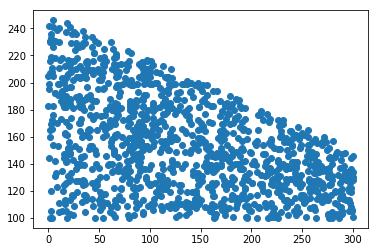

In [0]:
plt.scatter(df['exercise_time'],df['weight'])

In [0]:
#df.loc[df['exercise_time'] <0.0,'exercise_time']=0.0
#df.loc[df['exercise_time'] < 0.0

SyntaxError: ignored

In [0]:
# To analyse weight gain tendency on age
pd.crosstab(age_bins, weight_bins)


weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]"
age,,,,,
"(17.938, 30.4]",80,86,49,34,7
"(30.4, 42.8]",104,62,49,31,7
"(42.8, 55.2]",78,62,49,26,8
"(55.2, 67.6]",53,71,45,44,9
"(67.6, 80.0]",60,54,66,44,22


In [0]:
  pd.crosstab(age_bins, weight_bins, normalize='columns')

weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]"
age,,,,,
"(17.938, 30.4]",0.213333,0.256716,0.189922,0.189944,0.132075
"(30.4, 42.8]",0.277333,0.185075,0.189922,0.173184,0.132075
"(42.8, 55.2]",0.208000,0.185075,0.189922,0.145251,0.150943
"(55.2, 67.6]",0.141333,0.211940,0.174419,0.245810,0.169811
"(67.6, 80.0]",0.160000,0.161194,0.255814,0.245810,0.415094


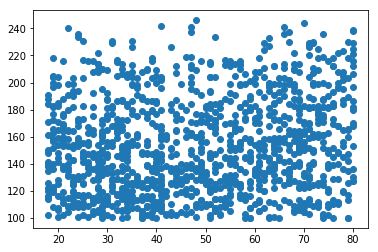

In [0]:
plt.scatter(df['age'],df['weight'])

In [0]:
dfolder=df[df.age>60]
dfolder.head()

,age,weight,exercise_time
12,73,209,44
17,69,172,147
25,71,103,21
27,79,189,38
28,72,149,110


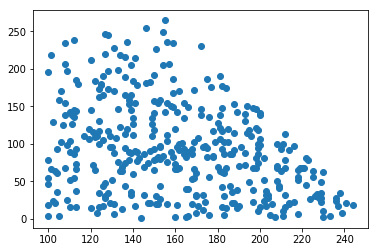

In [0]:
plt.scatter(dfolder['weight'],dfolder['exercise_time'])

In [0]:
pd.crosstab(age_bins, ex_time_bins)

exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
age,,,,,
"(17.938, 30.4]",52,46,54,61,43
"(30.4, 42.8]",52,55,42,47,57
"(42.8, 55.2]",41,42,39,34,67
"(55.2, 67.6]",46,71,40,41,24
"(67.6, 80.0]",87,102,48,9,0


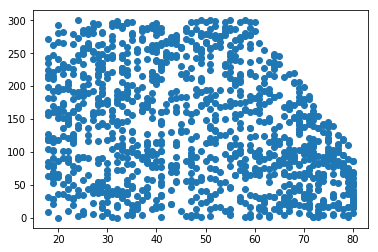

In [0]:
plt.scatter(df.age, df.exercise_time)

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


1) Age, weight and Exercise time all are continuous variable but in this data these are discrete variables

2) weight gain depends on exercise time. these two variables are real variable

3) age also depends on exercise time. people gets older and they spend less time on exercise but weight gain and age are not related to eachother so 
weight and age are suprious variables

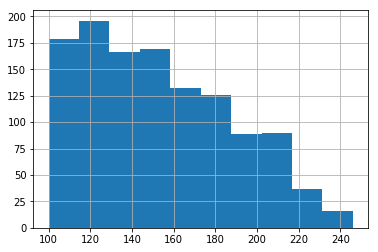

In [0]:
df.weight.hist()

/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'age' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


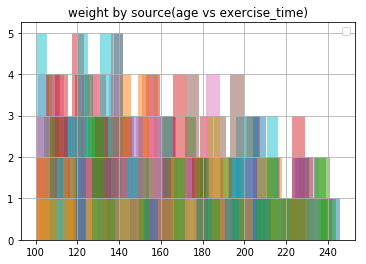

In [0]:
# For both age and weight
df.groupby('age').weight.hist(bins=20,alpha=0.5);
import matplotlib.pyplot as plt
plt.title('weight by source(age vs exercise_time)')
plt.legend(['age'],['exercise']);

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)